# Tennis-tracking using Image Processing
---
- Tracking a ball using tracknet.

## 1) Importing Libraries
---

In [1]:
import os
import csv
import cv2
import glob
import queue
import random
import argparse
import itertools
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from keras.models import *
from keras.layers import *
from keras import optimizers
from os.path import expanduser
from PIL import Image, ImageDraw
from keras.utils import plot_model
from scipy.spatial import distance as dist
from collections import defaultdict, OrderedDict

## 2) Converting the image into ground-truth
---

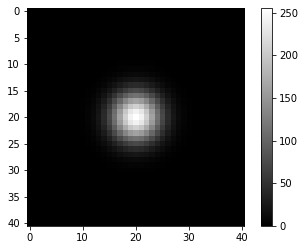

In [4]:
size = 20
#create gussian heatmap 
def gaussian_kernel(variance):
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g = np.exp(-(x**2+y**2)/float(2*variance))
    return g 


#make the Gaussian by calling the function
variance = 10
gaussian_kernel_array = gaussian_kernel(variance)
#rescale the value to 0-255
gaussian_kernel_array =  gaussian_kernel_array * 255/gaussian_kernel_array[int(len(gaussian_kernel_array)/2)][int(len(gaussian_kernel_array)/2)]
#change type as integer
gaussian_kernel_array = gaussian_kernel_array.astype(int)

#show heatmap 
plt.imshow(gaussian_kernel_array, cmap=plt.get_cmap('gray'), interpolation='nearest')
plt.colorbar()
plt.show()



#create the heatmap as ground truth
images_path = './Dataset/game1/'
dirs = glob.glob(images_path+'Clip*')

for index in dirs:
        pics = glob.glob(index + "/*.jpg")
        output_pics_path = images_path+'groundtruth/' + os.path.split(index)[-1]
        label_path = index + "/Label.csv"
        
        #check if the path need to be create
        if not os.path.exists(output_picgs_path ):
            os.makedirs(output_pics_path)

        #read csv file
        with open(label_path, 'r') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            #skip the headers
            next(spamreader, None)  
            
            for row in spamreader:
                    visibility = int(float(row[1]))
                    FileName = row[0]
                    #if visibility == 0, the heatmap is a black image
                    if visibility == 0:
                        heatmap = Image.new("RGB", (1280, 720))
                        pix = heatmap.load()
                        for i in range(1280):
                            for j in range(720):
                                    pix[i,j] = (0,0,0)
                    else:
                        x = int(float(row[2]))
                        y = int(float(row[3]))
                        
                        #create a black image
                        heatmap = Image.new("RGB", (1280, 720))
                        pix = heatmap.load()
                        for i in range(1280):
                            for j in range(720):
                                    pix[i,j] = (0,0,0)
                                    
                        #copy the heatmap on it
                        for i in range(-size,size+1):
                            for j in range(-size,size+1):
                                    if x+i<1280 and x+i>=0 and y+j<720 and y+j>=0 :
                                        temp = gaussian_kernel_array[i+size][j+size]
                                        if temp > 0:
                                            pix[x+i,y+j] = (temp,temp,temp)
                    #save image
                    heatmap.save(output_pics_path + "/" + FileName.split('.')[-2] + ".png", "PNG")


## 3) Generating Training image
---

In [142]:
#Output training data name to cvs file for model 1

tre_name = "training_model1.csv"
testing_file_aining_filname = "testing_model1.csv"
visibility_for_testing = []

images_path = './Dataset/game1/'
directories = []
annos_dire = []
for i in os.listdir(images_path):
    directories.append(os.path.join(images_path,i))
    annos_dire.append(os.path.join(images_path+'groundtruth/',i))

with open(training_file_name,'w') as file:
    for index in range(len(directories)-1):
        annos_path = annos_dire[index] + '/'
        images_path = directories[index]+'/'

        images = glob.glob(images_path + "*.jpg")
        images.sort()
        annotations  = glob.glob(annos_path + "*.png")
        annotations.sort()
        assert len( images ) == len(annotations)
        for im , seg in zip(images,annotations):
            im = 'r'+str(im)
            seg = 'r'+str(seg)
            assert(im.split('\\')[-1].split('.')[0] == seg.split('\\')[-1].split('.')[0])

        visibility = {}
        with open(images_path + "Label.csv", 'r') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            #skip the headers
            next(spamreader, None)  
            
            for row in spamreader:
                visibility[row[0]] = row[1]
                 
        #write all of images path
        for i in range(0,len(images)): 
                file_name = images[i]
                file_name = 'r'+str(file_name)
                file_name = file_name.split('\\')[-1]
                #visibility 3 will not be used for training
                if visibility[file_name] == '3':
                    visibility_for_testing.append(images[i])
                    
                #check if file image name same as annotation name
                assert( images[i].split('/')[-1].split(".")[0] ==  annotations[i].split('/')[-1].split(".")[0] )
                #write all of images path
                file.write(images[i] + "," + images[i-1] + "," + images[i-2] + "," + annotations[i] + "\n")
file.close()

#read all of images path
lines = open(training_file_name).read().splitlines()

#70% for training, 30% for testing 
training_images_number = int(len(lines)*0.7)
testing_images_number = len(lines) - training_images_number
print("Total images:", len(lines), "Training images:", training_images_number,"Testing images:", testing_images_number)

#shuffle the images
random.shuffle(lines)
#training images
with open(training_file_name,'w') as training_file:
    training_file.write("img, img1, img2, ann\n")
    #testing images
    with open(testing_file_name,'w') as testing_file:
        testing_file.write("img, img1, img2, ann\n")
        
        #write img, img1, img2, ann to csv file
        for i in range(0,len(lines)):
            if lines[i] != "":
                if training_images_number > 0 and lines[i].split(",")[0] not in visibility_for_testing :
                    training_file.write(lines[i] + "\n")
                    training_images_number -=1
                else:
                    testing_file.write(lines[i] + "\n")
training_file.close()
testing_file.close()
    

    
    

Total images: 19835 Training images: 13884 Testing images: 5951


## 4) Tracknet model
---

In [2]:
def TrackNet( n_classes ,  input_height, input_width ): # input_height = 360, input_width = 640

    imgs_input = Input(shape=(3,input_height,input_width))

    x = Conv2D(64, (3, 3), kernel_initializer='random_uniform', padding='same', data_format='channels_first' )(imgs_input)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    x = Conv2D(64, (3, 3), kernel_initializer='random_uniform', padding='same', data_format='channels_first' )(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    x = MaxPooling2D((2, 2), strides=(2, 2), data_format='channels_first' )(x)

    x = Conv2D(128, (3, 3), kernel_initializer='random_uniform', padding='same', data_format='channels_first' )(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    x = Conv2D(128, (3, 3), kernel_initializer='random_uniform', padding='same', data_format='channels_first' )(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    x = MaxPooling2D((2, 2), strides=(2, 2), data_format='channels_first' )(x)

    x = Conv2D(256, (3, 3), kernel_initializer='random_uniform', padding='same', data_format='channels_first' )(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    x = Conv2D(256, (3, 3), kernel_initializer='random_uniform', padding='same', data_format='channels_first' )(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    x = ( Conv2D(512, (3, 3), kernel_initializer='random_uniform', padding='same', data_format='channels_first'))(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    x = ( Conv2D( 256, (3, 3), kernel_initializer='random_uniform', padding='same', data_format='channels_first'))(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    x = ( Conv2D( 256, (3, 3), kernel_initializer='random_uniform', padding='same', data_format='channels_first'))(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    x = ( UpSampling2D( (2,2), data_format='channels_first'))(x)

    x = ( Conv2D( 128 , (3, 3), kernel_initializer='random_uniform', padding='same' , data_format='channels_first' ))(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    x = ( Conv2D( 128 , (3, 3), kernel_initializer='random_uniform', padding='same' , data_format='channels_first' ))(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    x = ( UpSampling2D( (2,2), data_format='channels_first'))(x)

    x = ( Conv2D( 64 , (3, 3), kernel_initializer='random_uniform', padding='same'  , data_format='channels_first' ))(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    x = ( Conv2D( 64 , (3, 3), kernel_initializer='random_uniform', padding='same'  , data_format='channels_first' ))(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    x =  Conv2D( n_classes , (3, 3) , kernel_initializer='random_uniform', padding='same', data_format='channels_first' )(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)

    o_shape = Model(imgs_input , x ).output_shape
    print("layer24 output shape:", o_shape[1],o_shape[2],o_shape[3])

    OutputHeight = o_shape[2]
    OutputWidth = o_shape[3]

    #reshape the size to (256, 360*640)
    x = (Reshape((  -1  , OutputHeight*OutputWidth   )))(x)

    #change dimension order to (360*640, 256)
    x = (Permute((2, 1)))(x)

    gaussian_output = (Activation('softmax'))(x)

    model = Model( imgs_input , gaussian_output)
    model.outputWidth = OutputWidth
    model.outputHeight = OutputHeight

    return model

## 5) Getting Data Ready to train
---

In [3]:
#get inut array
def getInputArr( path, width , height):
    try:
        #read the image
        img = cv2.imread(path, 1)
        #resize it 
        img = cv2.resize(img, ( width , height ))
        #input must be float type
        img = img.astype(np.float32)

        #since the odering of TrackNet  is 'channels_first', so we need to change the axis
        img = np.rollaxis(img, 2, 0)
        return img

    except Exception as e:
        print(path , e)



#get output array
def getOutputArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    try:
        img = cv2.imread(path, 1)
        img = cv2.resize(img, ( width , height ))
        img = img[:, : , 0]

        for c in range(nClasses):
            seg_labels[: , : , c ] = (img == c ).astype(int)

    except Exception as e:
        print(e)

    seg_labels = np.reshape(seg_labels, ( width*height , nClasses ))
    return seg_labels



#read input data and output data
def InputOutputGenerator( images_path,  batch_size,  n_classes , input_height , input_width , output_height , output_width ):
    #read csv file to 'zipped'
    columns = defaultdict(list)
    with open(images_path) as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            for (i,v) in enumerate(row):
                columns[i].append(v)
    zipped = itertools.cycle( zip(columns[0], columns[3]) )

    while True:
        Input = []
        Output = []
        #read input&output for each batch
        for _ in range( batch_size) :
            path, anno = next(zipped)
            Input.append( getInputArr(path, input_width , input_height) )
            Output.append( getOutputArr( anno , n_classes , output_width , output_height) )
        #return input&output
        yield np.array(Input) , np.array(Output)



## 6) Training the model
---

In [6]:
training_images_name = 'training_model1.csv'
train_batch_size = 2
n_classes = 256
input_height = 360
input_width = 640
epochs = 10
load_weights = -1
step_per_epochs = 200
optimizer_name = optimizers.Adadelta(lr=1.0)

#load TrackNet model
modelTN = TrackNet
m = modelTN( n_classes , input_height=input_height, input_width=input_width   )
m.compile(loss='categorical_crossentropy', optimizer= optimizer_name, metrics=['accuracy'])

#show TrackNet details, save it as TrackNet.png
plot_model( m , show_shapes=True , to_file='TrackNet.png')

#get TrackNet output height and width
model_output_height = m.outputHeight
model_output_width = m.outputWidth

#creat input data and output data
Generator  = InputOutputGenerator( training_images_name,  train_batch_size,  n_classes , input_height , input_width , model_output_height , model_output_width)

#start to train the model, and save weights until finish 
m.fit_generator( Generator, step_per_epochs, epochs )

m.save_weights( "weight.0" )

layer24 output shape: 256 360 640


C:\Users\Cobra\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
200/200 [==============================] - 516s 3s/step - loss: 0.1632 - accuracy: 0.9709
Epoch 2/10
200/200 [==============================] - 519s 3s/step - loss: 0.0055 - accuracy: 0.9996
Epoch 3/10
200/200 [==============================] - 515s 3s/step - loss: 0.0052 - accuracy: 0.9996
Epoch 4/10
200/200 [==============================] - 517s 3s/step - loss: 0.0050 - accuracy: 0.9996
Epoch 5/10
200/200 [==============================] - 514s 3s/step - loss: 0.0048 - accuracy: 0.9996
Epoch 6/10
200/200 [==============================] - 503s 3s/step - loss: 0.0046 - accuracy: 0.9996
Epoch 7/10
200/200 [==============================] - 425s 2s/step - loss: 0.0037 - accuracy: 0.9996
Epoch 8/10
200/200 [==============================] - 439s 2s/step - loss: 0.0034 - accuracy: 0.9996
Epoch 9/10
200/200 [==============================] - 461s 2s/step - loss: 0.0033 - accuracy: 0.9996
Epoch 10/10
200/200 [==============================] - 417s 2s/step - loss: 0.0034 - accura

In [7]:
new_weights =  TrackNet
new_weights = new_weights( 256 , input_height=360, input_width=640   )

new_weights.load_weights('weight.0')

layer24 output shape: 256 360 640


## Draw Court
---

In [8]:
def draw_court(img):

    # coordinates found manually
    x_1 = 574
    y_1 = 300

    x_2 = 1338
    y_2 = 300

    x_3 = 1570
    y_3 = 857

    x_4 = 358
    y_4 = 857

    cv2.line(img, (x_1, y_1), (x_2, y_2), (0, 0, 255), 2)
    cv2.line(img, (x_2, y_2), (x_3, y_3), (0, 0, 255), 2)
    cv2.line(img, (x_3, y_3), (x_4, y_4), (0, 0, 255), 2)
    cv2.line(img, (x_4, y_4), (x_1, y_1), (0, 0, 255), 2)

    return img

## Ball Tracking and Player Detection
---

In [9]:

def get_output_layers(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers


def binary(x):
    # transform an image in black and white
    if x == 0:
        return 0
    else:
        return 255


def remove_ball_boy(detected_person_img, lower_col, upper_col):
    # compute pixel percentage of a range of color (lower_col, upper_col)
    # in each box to detect ball boys/girls
    mask = cv2.inRange(detected_person_img, lower_col, upper_col)
    img = cv2.bitwise_and(detected_person_img, detected_person_img,mask=mask)
    func = np.vectorize(binary)
    img = func(img).astype(np.uint8)

    n_pix = img.shape[0] * img.shape[1]
    n_pix_bb = sum(img.flatten()) / img.shape[2] / 255

    return n_pix_bb / n_pix


def predict_players(outs, LABELS, img, confidence_threshold=0.8):
    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.8
    nms_threshold = 0.00000000001
    Width = img.shape[1]
    Height = img.shape[0]

    predicted_players = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > conf_threshold and LABELS[class_id] == 'person':
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                taux = remove_ball_boy(img[y:y + h, x:x + w],(27, 5, 40), (47, 40, 168))

                if taux < 0.01:
                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])

    # apply non-maxima suppression to suppress weak, overlapping
    # bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold,
                            nms_threshold)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            predicted_players.append((x, y, w, h))

    # sometimes, two identical frames remain
    predicted_players = list(set(predicted_players))

    return predicted_players


def update_boxes(box):
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    return x, y, x + w, y + h



class CentroidTracker():
    def __init__(self, maxDisappeared=300):
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()
        self.maxDisappeared = maxDisappeared

    def register(self, centroid):
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1

    def deregister(self, objectID):
        del self.objects[objectID]
        del self.disappeared[objectID]

    def update(self, rects):
        # check to see if the list of input bounding box rectangles
        # is empty
        if len(rects) == 0:
            # loop over any existing tracked objects and mark them
            # as disappeared
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1
                # if we have reached a maximum number of consecutive
                # frames where a given object has been marked as
                # missing, deregister it
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
            # return early as there are no centroids or tracking info
            # to update
            return self.objects

        # initialize an array of input centroids for the current frame
        inputCentroids = np.zeros((len(rects), 2), dtype="int")
        # loop over the bounding box rectangles
        for (i, (startX, startY, endX, endY)) in enumerate(rects):
            # use the bounding box coordinates to derive the centroid
            cX = int((startX + endX) / 2.0)
            cY = int(endY)
            inputCentroids[i] = (cX, cY)

        if len(self.objects) == 0:
            for i in range(0, len(inputCentroids)):
                self.register(inputCentroids[i])

        else:
            # grab the set of object IDs and corresponding centroids
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())
            
            D = dist.cdist(np.array(objectCentroids), inputCentroids)

            rows = D.min(axis=1).argsort()

            cols = D.argmin(axis=1)[rows]

            usedRows = set()
            usedCols = set()
            for (row, col) in zip(rows, cols):
                if row in usedRows or col in usedCols:
                    continue
                objectID = objectIDs[row]
                self.objects[objectID] = inputCentroids[col]
                self.disappeared[objectID] = 0
                # indicate that we have examined each of the row and column indexes, respectively
                usedRows.add(row)
                usedCols.add(col)

            # compute both the row and column index we have NOT yet
            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)

            if D.shape[0] >= D.shape[1]:
                # loop over the unused row indexes
                for row in unusedRows:
                    # grab the object ID for the corresponding row
                    # index and increment the disappeared counter
                    objectID = objectIDs[row]
                    self.disappeared[objectID] += 1
                    if self.disappeared[objectID] > self.maxDisappeared:
                        self.deregister(objectID)

            # otherwise, if the number of input centroids is greater
            # than the number of existing object centroids we need to
            # register each new input centroid as a trackable object
            else:
                for col in unusedCols:
                    self.register(inputCentroids[col])
        # return the set of trackable objects
        return self.objects

## Predicting an Output
---

In [10]:

input_video_path =  './video_input2.mp4'
output_video_path =  'output_Final_2.mp4'
save_weights_path = 'weight.0'
n_classes =  256

#get video fps&video size
video = cv2.VideoCapture(input_video_path)
fps = int(video.get(cv2.CAP_PROP_FPS))
output_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
output_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

#start from first frame
currentFrame = 0

#width and height in TrackNet
width , height = 640, 360
img, img1, img2 = None, None, None

#load TrackNet model
modelFN = TrackNet
m = modelFN( n_classes , input_height=height, input_width=width   )
m.compile(loss='categorical_crossentropy', optimizer= 'adadelta' , metrics=['accuracy'])
m.load_weights(  save_weights_path  )

# In order to draw the trajectory of tennis, we need to save the coordinate of preious 7 frames 
q = queue.deque()
for i in range(0,8):
    q.appendleft(None)

#save prediction images as vidoe
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_video_path,fourcc, fps, (output_width,output_height))

LABELS = open('./Yolov3/yolov3.txt').read().strip().split("\n")
net = cv2.dnn.readNet('./Yolov3/yolov3.weights', './Yolov3/yolov3.cfg')
ct_players = CentroidTracker()
# append players positions at each frame
players_positions = {'x_0': [], 'y_0': [], 'x_1': [], 'y_1': []}


while(True):

    #capture frame-by-frame
    video.set(1,currentFrame); 
    ret, img = video.read()

    #if there dont have any frame in video, break
    if not ret: 
        break
    
     # detect players
    scale = 0.00392
    blob = cv2.dnn.blobFromImage(img, scale, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(get_output_layers(net))
    detected_players = predict_players(outs, LABELS, img, 0.8)

    # track players with a unique ID
    formate_detected_players = list(map(update_boxes, list(detected_players)))
    players_objects = ct_players.update(formate_detected_players)

    # players positions frame by frame
    players_positions['x_0'].append(tuple(players_objects[0])[0])
    players_positions['y_0'].append(tuple(players_objects[0])[1])
    players_positions['x_1'].append(tuple(players_objects[1])[0])
    players_positions['y_1'].append(tuple(players_objects[1])[1])

    
    #img is the frame that TrackNet will predict the position
    #since we need to change the size and type of img, copy it to output_img
    output_img = img

    #resize it 
    img = cv2.resize(img, ( width , height ))
    #input must be float type
    img = img.astype(np.float32)

    #since the odering of TrackNet  is 'channels_first', so we need to change the axis
    X = np.rollaxis(img, 2, 0)
    #prdict heatmap
    pr = m.predict( np.array([X]) )[0]

    pr = pr.reshape(( height ,  width , n_classes ) ).argmax( axis=2 )

    #cv2 image must be numpy.uint8, convert numpy.int64 to numpy.uint8
    pr = pr.astype(np.uint8) 

    #reshape the image size as original input image
    heatmap = cv2.resize(pr  , (output_width, output_height ))

    #heatmap is converted into a binary image by threshold method.
    ret,heatmap = cv2.threshold(heatmap,127,255,cv2.THRESH_BINARY)

    #find the circle in image with 2<=radius<=7
    circles = cv2.HoughCircles(heatmap, cv2.HOUGH_GRADIENT,dp=1,minDist=1,param1=50,param2=2,minRadius=2,maxRadius=7)
    
    output_img = draw_court(output_img)
    
     # draw players boxes
    color_box = (0, 0, 255)
    if len(detected_players) > 0:
        for box in detected_players:
            x, y, w, h = box
            cv2.rectangle(output_img, (x, y), (x + w, y + h), color_box, 2)

    # draw tracking id of each player
    for (objectID, centroid_player)in players_objects.items():
        # draw both the ID of the object and the centroid of the
        # object on the output frame
        text = "ID {}".format(objectID)
        cv2.putText(output_img, text, (centroid_player[0] - 50, centroid_player[1]),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
        cv2.circle(output_img, (centroid_player[0], centroid_player[1]), 1, (0, 255, 0), 2)
    
    #In order to draw the circle in output_img, we need to use PIL library
    PIL_image = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)   
    PIL_image = Image.fromarray(PIL_image)
    
    #check if there have any tennis be detected
    if circles is not None:
        #if only one tennis be detected
        if len(circles) == 1:

            x = int(circles[0][0][0])
            y = int(circles[0][0][1])
            print(currentFrame, x,y)

            #push x,y to queue
            q.appendleft([x,y])   
            #pop x,y from queue
            q.pop()    
        else:
            #push None to queue
            q.appendleft(None)
            #pop x,y from queue
            q.pop()
    else:
        #push None to queue
        q.appendleft(None)
        #pop x,y from queue
        q.pop()

    #draw current frame prediction and previous 7 frames as yellow circle, total: 8 frames
    for i in range(0,8):
        if q[i] is not None:
            draw_x = q[i][0]
            draw_y = q[i][1]
            bbox =  (draw_x - 2, draw_y - 2, draw_x + 2, draw_y + 2)
            draw = ImageDraw.Draw(PIL_image)
            draw.ellipse(bbox, outline ='yellow')
            del draw

    #Convert PIL image format back to opencv image format
    opencvImage =  cv2.cvtColor(np.array(PIL_image), cv2.COLOR_RGB2BGR)
    #write image to output_video
    output_video.write(opencvImage)

    #next frame
    currentFrame += 1

# everything is done, release the video
video.release()
output_video.release()

layer24 output shape: 256 360 640
27 901 648
28 894 652
29 882 660
30 873 664
31 873 664
32 864 666
36 829 702
37 827 704
38 822 712
39 819 724
40 807 736
41 801 748
42 793 763
43 793 763
46 786 732
51 810 642
52 816 624
53 819 604
54 828 582
55 828 582
56 822 564
57 834 552
66 858 432
67 858 432
68 870 426
69 865 432
70 874 418
71 873 406
72 879 399
73 879 399
74 876 390
75 883 384
76 886 378
77 888 370
78 894 366
79 888 364
80 899 359
81 894 352
82 894 348
83 902 344
84 903 340
85 903 340
86 900 321
87 909 334
88 907 330
89 913 324
90 913 325
91 914 323
92 918 318
93 918 318
98 924 312
102 930 312
103 930 312
105 930 312
106 930 312
107 930 312
108 930 312
109 930 312
111 946 322
112 940 324
114 942 324
115 942 324
118 948 330
119 945 324
137 945 246
138 942 246
139 942 246
141 930 252
145 918 258
147 906 270
155 867 327
156 855 334
157 855 334
158 855 346
159 853 357
160 836 371
161 840 387
164 825 402
165 822 414
176 768 558
177 768 576
179 750 618
180 750 636
181 750 636
182 744 6